# Random forest and tree correlation 

We vary the two main parameters in random forest that influence the correlation of the member trees.

In [1]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
import pandas as pd
import time
import scipy

Let's set up a method to compute the average correlation coefficient over the trees in a random forest. The actual correlation coefficient between two trees is computed by the method <code>scipy.stats.pearsonr</code>. The only issue below is that we have to be careful with the classes, as internally the trees of random forest always work with an enumeration 0,1,2,... of the classes. That is, if the actualy classes are 'cat', 'dog' and 'T-Rex' then the trees will predict 0,1 or 2. 

In [2]:
def avg_corr_coeff(rf,X_test,y_test):
    result=[]
    for i,tree1 in enumerate(rf.estimators_):
        ## rf.classes_ stores the class names
        ## the individual trees work with classes 0,1,2,...
        correct1=rf.classes_[tree1.predict(X_test).astype('int')]==y_test
        for tree2 in rf.estimators_[i+1:]:
            correct2=rf.classes_[tree2.predict(X_test).astype('int')]==y_test
            result.append(scipy.stats.pearsonr(correct1,correct2).statistic)
    return np.mean(result)

## The dataset

We use here an old dataset on satellite data. This is mainly because with 36 features the dataset is not trivial but also not very high-dimensional. I'd expect random forest to struggle with a high-dimensional dataset. 

In [3]:
from sklearn.datasets import fetch_openml
data = fetch_openml('satellite_image', cache=True)
print(data.DESCR)
X, y = data["data"], data["target"]
X=X.values
X.shape

/home/henning/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


**Author**:   
**Source**: Unknown - 1993  
**Please cite**:   

Source:
Ashwin Srinivasan
Department of Statistics and Data Modeling
University of Strathclyde
Glasgow
Scotland
UK
ross '@' uk.ac.turing

The original Landsat data for this database was generated from data purchased from NASA by the Australian Centre for Remote Sensing, and used for research at: 
The Centre for Remote Sensing
University of New South Wales
Kensington, PO Box 1
NSW 2033
Australia.

The sample database was generated taking a small section (82 rows and 100 columns) from the original data. The binary values were converted to their present ASCII form by Ashwin Srinivasan. The classification for each pixel was performed on the basis of an actual site visit by Ms. Karen Hall, when working for Professor John A. Richards, at the Centre for Remote Sensing at the University of New South Wales, Australia. Conversion to 3x3 neighbourhoods and splitting into test and training sets was done by Alistair Sutherland.

Data 

(6435, 36)

## Correlation by bootstrap size
First we vary the number of samples considered for the bootstrap training set of the individual trees. In *scikit-learn* the size can be controlled with the parameter <code>max_samples</code>. If <code>max_samples</code> is a float in $[0,1]$ then the bootstrapped training set has a size equal to <code>max_samples</code> times the total size of the training set. For comparison, we also compute a random forest without bootstrap (ie, the whole training set will be used for each of the individual trees) and a decision tree. We repeat each experiment <code>repeat</code> often to ensure a bit of statistical stability.

In [4]:
train_size=4435
n_estimators=20
repeats=10 # should probably use larger number of repeats, but I am impatient
max_samples_=[0.01,0.05,0.1,0.2,0.5,1.]
try:
    result2=pd.read_csv("rf_corr2.csv")
except:
    start=time.time()
    result_table=[]
    for max_samples in max_samples_:
        for r in range(repeats):
            X, y = sklearn.utils.shuffle(X,y)
            X_train,X_test=X[:train_size],X[train_size:]
            y_train,y_test=y[:train_size],y[train_size:]

            rf=RandomForestClassifier(n_estimators=n_estimators,max_samples=max_samples,bootstrap=True)
            rf.fit(X_train,y_train)
            corr_coeff=avg_corr_coeff(rf,X_test,y_test)
            loss=zero_one_loss(rf.predict(X_test),y_test)
            result_table.append(['rf',r+1,max_samples,corr_coeff,loss])

            rf_no_bootstrap=RandomForestClassifier(n_estimators=n_estimators,bootstrap=False)
            rf_no_bootstrap.fit(X_train,y_train)
            corr_coeff=avg_corr_coeff(rf_no_bootstrap,X_test,y_test)
            loss=zero_one_loss(rf_no_bootstrap.predict(X_test),y_test)
            result_table.append(['rf_no_bootstrap',r+1,42,corr_coeff,loss])

            tree=DecisionTreeClassifier()
            tree.fit(X_train,y_train)
            loss=zero_one_loss(tree.predict(X_test),y_test)
            result_table.append(['tree',r+1,42,42,loss])
    
    result2=pd.DataFrame(result_table,columns=['algo','repeat_num','max samples','correlation coefficient','zero one loss'])

    print("total running time: {:.2f}s".format(time.time()-start))
    # let's save the data as it takes a while to compute it
    result2.to_csv("rf_corr2.csv",index=False)

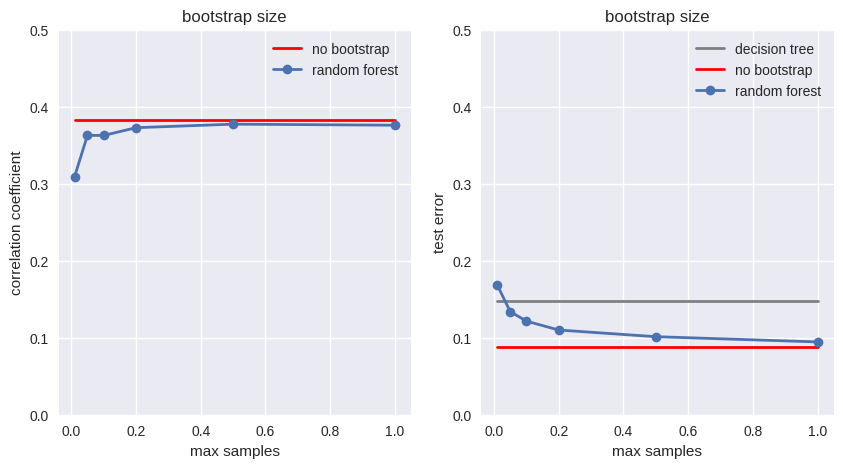

In [5]:
means=result2[result2['algo']=='rf'] \
    .drop(columns=['algo']) \
    .groupby("max samples").mean()
tree_mean=result2.loc[result2['algo']=='tree','zero one loss'].mean()
no_bootstrap_corr=result2.loc[result2['algo']=='rf_no_bootstrap','correlation coefficient'].mean()
no_bootstrap_loss=result2.loc[result2['algo']=='rf_no_bootstrap','zero one loss'].mean()
fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].plot(means.index,[no_bootstrap_corr]*len(means),'red',linewidth=2,label="no bootstrap")
axs[0].plot(means.index,means['correlation coefficient'],'o-',linewidth=2,label="random forest")
axs[0].set_ylabel('correlation coefficient')
axs[0].set_xlabel('max samples')
axs[0].set_ylim(0,0.5)
axs[0].set_title("bootstrap size")
axs[0].legend()

axs[1].plot(means.index,[tree_mean]*len(means),'gray',linewidth=2,label="decision tree")
axs[1].plot(means.index,[no_bootstrap_loss]*len(means),'red',linewidth=2,label="no bootstrap")
axs[1].plot(means.index,means['zero one loss'],'o-',linewidth=2,label="random forest")
axs[1].set_ylabel('test error')
axs[1].set_xlabel('max samples')
axs[1].set_ylim(0,0.5)
axs[1].set_title("bootstrap size")
axs[1].legend()

On the left we observe that the correlation coefficient only becomes smaller for very small bootstrap sizes. These, however, result in a high test error. We also see that random forest is indeed an improvement over a simple decision tree. A somewhat surprising result: Random forest without bootstrap performs best.

## Correlation by number of used features
Next, we investigate how the number of features that is used to build the individual trees impacts correlation coefficient and test error. The number of features is controled by the parameter <code>max_features</code>. By default this number is fixed to $\sqrt d$, where $d$ is the dimensionality of the training set. Again, we also compute a decision tree and random forest without bootstrap (but with varying <code>max_features</code>). Again, each experiment is repeated <code>repeat</code> times to ensure statistical stability.

In [6]:
train_size=4435
n_estimators=20
repeats=20
max_features_=np.linspace(0.1,1,5)
n_features_in_=X.shape[1]
try:
    result=pd.read_csv("rf_corr.csv")
except:
    start=time.time()
    result_table=[]
    for max_features in max_features_:
        for r in range(repeats):
            X, y = sklearn.utils.shuffle(X,y)
            X_train,X_test=X[:train_size],X[train_size:]
            y_train,y_test=y[:train_size],y[train_size:]

            rf=RandomForestClassifier(n_estimators=n_estimators,max_features=max_features)
            rf.fit(X_train,y_train)
            corr_coeff=avg_corr_coeff(rf,X_test,y_test)
            loss=zero_one_loss(rf.predict(X_test),y_test)
            num_features=max(1, int(max_features * n_features_in_))
            result_table.append(['rf',r+1,num_features,corr_coeff,loss])

            rf_no_bootstrap=RandomForestClassifier(n_estimators=n_estimators,bootstrap=False,max_features=max_features)
            rf_no_bootstrap.fit(X_train,y_train)
            corr_coeff=avg_corr_coeff(rf_no_bootstrap,X_test,y_test)
            loss=zero_one_loss(rf_no_bootstrap.predict(X_test),y_test)
            result_table.append(['rf_no_bootstrap',r+1,num_features,corr_coeff,loss])
    
            tree=DecisionTreeClassifier()
            tree.fit(X_train,y_train)
            loss=zero_one_loss(tree.predict(X_test),y_test)
            result_table.append(['tree',r+1,42,42,loss])

    result=pd.DataFrame(result_table,columns=['algo','repeat_num','max features','correlation coefficient','zero one loss'])

    print("total running time: {:.2f}s".format(time.time()-start))
    # let's save the data as it takes a while to compute it
    result.to_csv("rf_corr.csv",index=False)

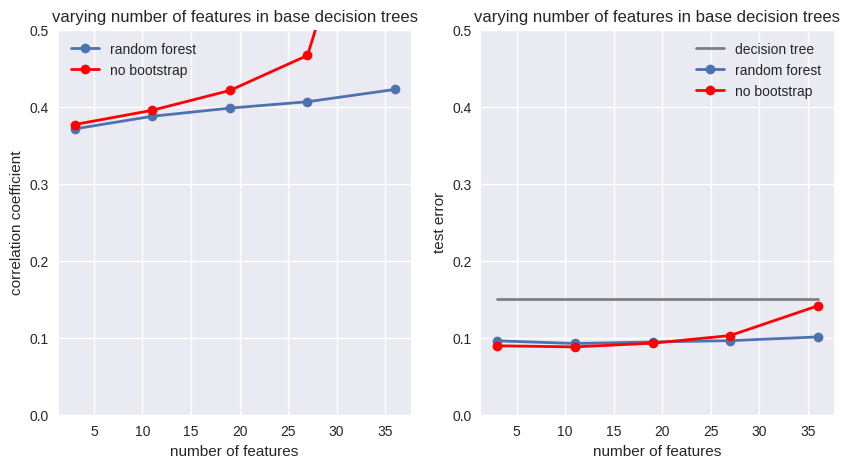

In [7]:
means=result[result['algo']=='rf'] \
    .drop(columns=['algo']) \
    .groupby("max features").mean()
nobs_means=result[result['algo']=='rf_no_bootstrap'] \
    .drop(columns=['algo']) \
    .groupby("max features").mean()
tree_mean=result.loc[result['algo']=='tree','zero one loss'].mean()

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].plot(means.index,means['correlation coefficient'],'o-',linewidth=2,label="random forest")
axs[0].plot(nobs_means.index,nobs_means['correlation coefficient'],'ro-',linewidth=2,label="no bootstrap")
axs[0].set_ylabel('correlation coefficient')
axs[0].set_xlabel('number of features')
axs[0].set_ylim(0,0.5)
axs[0].set_title("varying number of features in base decision trees")
axs[0].legend()

axs[1].plot(means.index,[tree_mean]*len(means),'gray',linewidth=2,label="decision tree")
axs[1].plot(means.index,means['zero one loss'],'o-',linewidth=2,label="random forest")
axs[1].plot(nobs_means.index,nobs_means['zero one loss'],'ro-',linewidth=2,label="no bootstrap")
axs[1].set_ylabel('test error')
axs[1].set_xlabel('number of features')
axs[1].set_ylim(0,0.5)
axs[1].set_title("varying number of features in base decision trees")
axs[1].legend()

First observation: increasing <code>max_features</code> leads to greater correlation coefficient. The relationship, however, is somewhat weak. Interestingly, for random forest without bootstrap larger <code>max_features</code> drives up the correlation coefficient much faster. Also interesting: the test error is largely unaffected by the larger number of features, only without bootstrap and only for very large numbers of features we see a deterioration of the test error. What is remarkable: Even if *all* features are used, we still see the same small test error. Apparently, it is enough that there is some source of randomness, either bootstrap or a restriction on the number of used features, the ensure largely the same performance of random forest. 

The experiments here concern only a single dataset, so it'd be foolish to draw general conclusions from them. Perhaps one insight can be gleaned, though: Random forest is relatively uncomplicated. As long as the hyper-parameters of random forest are set to *reasonable* values, the algorithm will probably work just fine.